# GAN (Generative Adversarial Networks)

En este practico vamos a estar implementando el modelo generativo [GAN (Generative Adversarial Networks)](https://arxiv.org/pdf/1406.2661)

In [1]:
import math
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from mpl_toolkits.axes_grid1 import ImageGrid

ModuleNotFoundError: No module named 'tqdm'

In [ ]:
# Transformamos los datos a tensores y los normalizamos
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])

# Descargamos el dataset
dataset = datasets.FashionMNIST(root='./data', download=True, transform=transform)

# Creamos el dataloader
batch_size = 64
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Running on {device}")

In [ ]:
def show_imgs(imgs, title="Images"):
    plt.figure(figsize=(5,5))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(vutils.make_grid(imgs, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()

real_batch = next(iter(dataloader))[0][:64]
img_shape = real_batch[0].shape
show_imgs(real_batch)

## Definimos el modelo
Las GANs (Generative Adversarial Networks) consisten en dos redes que compiten entre sí: un generador que crea datos falsos y un discriminador que trata de distinguirlos de los datos reales, mejorando así la calidad de los datos generados con el tiempo.

### Generador
Es una red neuronal que, partiendo de un espacio latente, crea datos sintéticos con el objetivo de parecerse a los datos reales.

Esta "parte" del modelo es la que nos va a servir luego para la generación.

In [20]:
class Generator(nn.Module):
    def __init__(self, latent_dim, number_feature_maps, output_channels):
        super(Generator, self).__init__()
        self.latent_feature_maps = latent_dim
        self.main = nn.Sequential(
            # Tamaño entrada (bs, tamaño latente, 1, 1)
            nn.ConvTranspose2d(latent_dim, number_feature_maps * 4, 7, 1, 0, bias=False),
            nn.BatchNorm2d(number_feature_maps * 4),
            nn.ReLU(True),
            # Tamaño (bs, number_feature_maps*4, 7 , 7)
            nn.ConvTranspose2d(number_feature_maps * 4, number_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_feature_maps * 2),
            nn.ReLU(True),
            # Tamaño (bs, number_feature_maps*2, 14 , 14)
            nn.ConvTranspose2d(number_feature_maps * 2, number_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_feature_maps),
            nn.ReLU(True),
            # Tamaño (bs, number_feature_maps, 28 , 28)
            nn.ConvTranspose2d(number_feature_maps, output_channels, 3, 1, 1, bias=False),
            nn.Tanh(),
            # Tamaño salida (bs, 1, 28 , 28)
        )

    def forward(self, input):
        result = self.main(input)
        return result

### Discriminador

Es una red neuronal que clasifica los datos como reales o generados. Su tarea es distinguir entre los datos reales y los falsos producidos por el generador, ayudando así a mejorar la calidad de ambos.

In [21]:
class Discriminator(nn.Module):
    def __init__(self, input_channels, number_feature_maps, output_dim):
        super(Discriminator, self).__init__()
        self.conv_layers = nn.Sequential(
            # Tamaño entrada (bs, 1, 28, 28)
            nn.Conv2d(input_channels, number_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_feature_maps),
            nn.LeakyReLU(0.2, inplace=True),
            # Tamaño (bs, number_feature_maps, 14, 14)
            nn.Conv2d(number_feature_maps, number_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Tamaño (bs, number_feature_maps*2, 7, 7)
            nn.Conv2d(number_feature_maps * 2, number_feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Tamaño (bs, number_feature_maps*4, 4, 4)
        )

        self.fully_connected = nn.Sequential(
            nn.Flatten(1),
            # Tamaño (bs, 3*3*number_feature_maps*4)
            nn.Linear(3*3*number_feature_maps*4, output_dim),
            nn.Sigmoid()
        )

    def forward(self, input):
        res = self.conv_layers(input)
        res = self.fully_connected(res)
        return res

## Definición de hyperparámetros y creación del modelo.

In [22]:
# Definimos hyperparámetros
latent_dim = ...
discriminator_lr = 0.0002
generator_lr = 0.002
n_epochs = 12

# Creamos el generador y el discriminador
generator = ...
discriminator = ...

# Definir la función de pérdida
adversarial_loss = ...

In [23]:
# Definimos la función de entrenamiento del modelo
def train(generator, discriminator, adversarial_loss, dataloader, n_epochs, device, verbose=False):
    # Creamos los dos optimizadores. 
    # Recordar que estos optimizadores son distintos ya que cada uno precisa los parametros
    #    a entrenar y el discriminador y el generador se entrenan por separado.
    optimizer_G = optim.Adam(generator.parameters(), lr=generator_lr)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=discriminator_lr)

    for epoch in tqdm(range(n_epochs)):
        for i, (imgs, _) in enumerate(dataloader):
            bs = imgs.size(0)

            # Creamos las etiquetas para el discriminador
            valid = ...
            fake = ...

            real_imgs = imgs.to(device)

            # Creamos ruido dentro del espacio latente usando una normal
            latent_shape = (bs, latent_dim, 1, 1)
            z = ...
            z = z.to(device)

            
            # Entrenar el generador
            g_loss = ...
            gen_imgs = ...

            # Entrenar el discrminador (recordar hacer el detach de las imagenes generadas)
            d_loss = ...

            if verbose: print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

        if epoch % 4 == 0:
                show_imgs(gen_imgs.data[:32], title=f"Epoch {epoch}")
            


## Entrenamiento del modelo

In [ ]:
# Comenzamos el entrenamiento del modelo!
train(generator, discriminator, adversarial_loss, dataloader, n_epochs, device)

## Generación de datos

In [ ]:
def generate(generator, num_imgs=32):
    # Creamos un tensor de ruido dentro del espacio latente
    z = ...
    # Hacemos el forward pass del generador
    gen_imgs = generator(z)
    return gen_imgs

imgs = generate(generator, num_imgs=64)
show_imgs(imgs, title="Generated Images")

## Ejercicios:

1. Complete el codigo faltante y entrene una GAN que genere imágenes de Fashion MNIST.
2. Responda las siguientes preguntas:
    - ¿En qué afecta el tamaño del espacio latente?
    - ¿Por qué entrenamos al discriminador y al generador alternativamente?
    - ¿Qué tamaño tiene la salida del discriminador y por qué? ¿Y el generador?
    - ¿Qué tipo de activación final se usa en el discriminador y por qué?
    - ¿Cuál es el propósito de la competencia entre el generador y el discriminador en las GANs? Explica cómo esto contribuye a la mejora del modelo.
    - Entrene una GAN que genere imágenes del dataset [SVHN (street view house number)](http://ufldl.stanford.edu/housenumbers/).
    - Comente los resultados obtenidos con este dataset.

Estas imágenes son de (3, 32, 32). Debe crear un nuevo generador y dicriminador para ajustarse a estas nuevas dimensiones.

Image size: torch.Size([3, 32, 32])


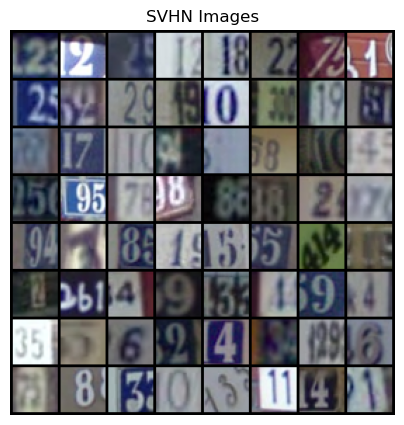

In [35]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0, 1)
    ])

dataset = datasets.SVHN(root='./data', download=True, transform=transform)
print(f"Image size: {dataset[0][0].shape}")

batch_size = 64
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
real_batch = next(iter(dataloader))[0]
img_shape = real_batch[0].shape
show_imgs(real_batch, "SVHN Images")